In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
# helper function to show images
def plot(image, title="title"):
    plt.axis('off')
    plt.title(title)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [3]:
# helper function to convert RGB to grayscale
def to_grayscale(img):
    img_arr = np.array(img)
    gray = np.dot(img_arr, [0.299, 0.587, 0.114])
    
    img_gray = Image.fromarray(gray.astype(np.uint8))
    
    return img_gray

# Winner-Take-All stereo algorithm 

### Part 1: Rank Transform

In [4]:
def rank_transform(image):
    # specify window size
    window = 5
    
    mid = int((window - 1) / 2)
    
    # convert image to array
    arr = np.asarray(image)
    
    # get width and height of image
    width = arr.shape[0]
    height = arr.shape[1]
    
    # create empty array for output
    arr_out = np.zeros((width, height))
    
    # loop through entire image
    for i in range(width):
        for j in range(height):
            # loop through window
            for u in range(i-mid, i+mid+1):
                for v in range(j-mid, j+mid+1):
                    # condition to check pixel values
                    if (0<=u<width and 0<=v<height):
                        if (arr[u][v] < arr[i][j]):
                            arr_out[i][j] += 1
                            
    arr_out = arr_out.astype(np.uint16)
    #print(arr_out)
    
    return arr_out

### Part 2: Calculate disparity map

In [5]:
def get_disparity_map(img_left, img_right, window, disparity_range):
    # similar to above method but here instead of storing
    # neighbor values, we calculate disparity based on
    # absolute differences
    
    mid = int((window - 1) / 2)
    
    # get image dimensions
    width = img_right.shape[0]
    height = img_right.shape[1]
    
    # create an empty array for disparity map
    disparity_map = np.zeros((width, height))
    
    # loop through image
    for i in range(width):
        for j in range(height):
            # initialize starting disparity as -1 and differnce (absolute)
            # to some large value
            
            diff = float('inf')
            val = -1
            
            # range of disparity values 0 to 63
            for value in range(disparity_range):
                tot = 0
                
                # loop through window
                for u in range(i-mid, i+mid+1):
                    for v in range(j-mid, j+mid+1):
                        # condition
                        if (0<=u<width and 0<=v<height and 0<=(v+value)<height):
                            tot += abs(int(img_right[u][v]) - int(img_left[u][v+value]))
                        elif (0<=u<width and 0<=v<height and height<=(v+value)):
                            tot += abs(int(img_right[u][v]) - int(0))
                
                if (tot < diff):
                    diff = tot
                    val = value
                    
            disparity_map[i][j] = val
    
    # convert disparity map into image
    disparity_map = disparity_map.astype(np.uint8)
    disparity_img = Image.fromarray(disparity_map)
    
    return disparity_img

### Part 3: Calculate error rate

In [6]:
def error(pred, true):
    # convert disparities into arrays
    arr1 = np.asarray(pred)
    arr2 = np.asarray(true)
    
    # get image dimensions
    width = arr1.shape[0]
    height = arr1.shape[1]
    
    # get pixel count, product of image dimensions
    num_pixels = width * height
    
    # initialize bad pixels
    bad_pixels = 0
    
    # loop through image
    for i in range(width):
        for j in range(height):
            # round the values
            r_val = round(arr2[i][j]/4)
            
            # condition to check for bad pixel
            if (arr1[i][j]-r_val > 1 or arr1[i][j]-r_val < -1):
                bad_pixels += 1
    
    # get ratio of bad pixels to all
    ratio = float(bad_pixels) / float(num_pixels)
    error_rate = ratio * 100
    
    return error_rate

## Implementation on Teddy stereo

In [7]:
def teddy():
    # open left and right images
    teddy_left = Image.open("teddy/teddyL.pgm")
    teddy_right = Image.open("teddy/teddyR.pgm")
    
    #print(teddy_left.size)
    #print(teddy_right.size)
    
    # open true image
    true = Image.open("teddy/disp2.pgm")
    
    # calculate rank transform
    teddy_left_rt = rank_transform(teddy_left)
    teddy_right_rt = rank_transform(teddy_right)
    
    # disparity with window size == 3
    pred_3x3 = get_disparity_map(teddy_left_rt, teddy_right_rt, 3, 64)
    error_3x3 = error(pred_3x3, true)
    plot(pred_3x3, title="Teddy Stereo Disparity 3x3")
    print(f"Teddy Stereo error rate with window size 3: {round(error_3x3, 3)}%")
    
    # disparity with window size == 15
    pred_15x15 = get_disparity_map(teddy_left_rt, teddy_right_rt, 15, 64)
    error_15x15 = error(pred_15x15, true)
    plot(pred_15x15, title="Teddy Stereo Disparity 15x15")
    print(f"Teddy Stereo error rate with window size 15: {round(error_15x15, 3)}%")

## Implementation of Fish Stereo

In [8]:
def fish():
    fish_left = Image.open("fish1.jpg")
    fish_right = Image.open("fish2.jpg")
    
    fish_left_gray = to_grayscale(fish_left)
    fish_right_gray = to_grayscale(fish_right)
    
    fish_left_rt = rank_transform(fish_left_gray)
    fish_right_rt = rank_transform(fish_right_gray)
    
    #######
    # 3x3 #
    #######
    disp_3x3 = get_disparity_map(fish_left_rt, fish_right_rt, 3, 64)
    plot(disp_3x3, title="Disparity 3x3 Range (0,64)")
    
    disp_3x3_128 = get_disparity_map(fish_left_rt, fish_right_rt, 3, 128)
    plot(disp_3x3_128, title="Disparity 3x3 Range (0,128)")
    
    '''
    #######
    # 7x7 #
    #######
    disp_7x7 = get_disparity_map(fish_left_rt, fish_right_rt, 7, 64)
    plot(disp_7x7, title="Disparity 7x7 Range (0,64)")
    
    disp_7x7_128 = get_disparity_map(fish_left_rt, fish_right_rt, 7, 128)
    plot(disp_7x7_128, title="Disparity 7x7 Range (0,128)")
    '''
    
    #########
    # 15x15 #
    #########
    disp_15x15 = get_disparity_map(fish_left_rt, fish_right_rt, 15, 64)
    plot(disp_15x15, title="Disparity 15x15 Range (0,64)")
    
    disp_15x15_128 = get_disparity_map(fish_left_rt, fish_right_rt, 15, 128)
    plot(disp_15x15_128, title="Disparity 15x15 Range (0,128)")

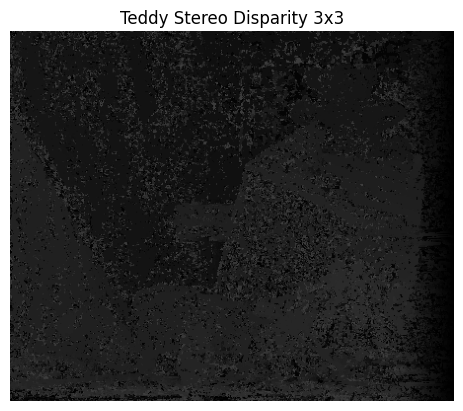

Teddy Stereo error rate with window size 3: 63.714%


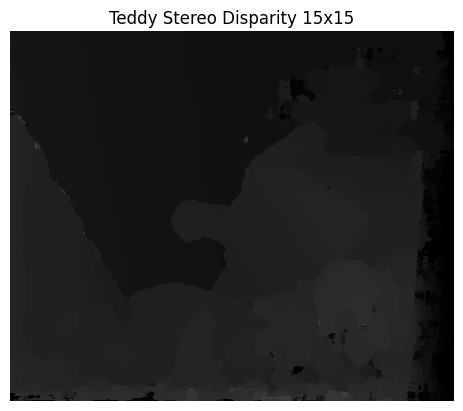

Teddy Stereo error rate with window size 15: 44.507%


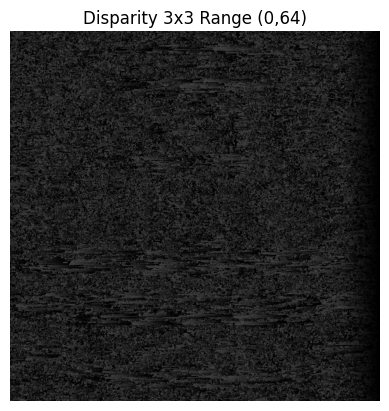

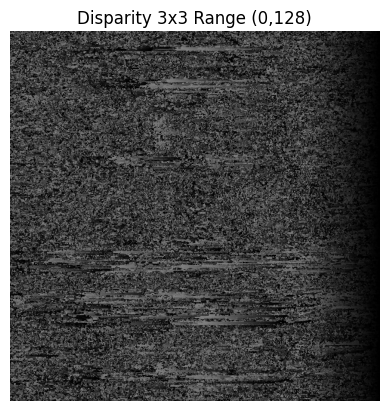

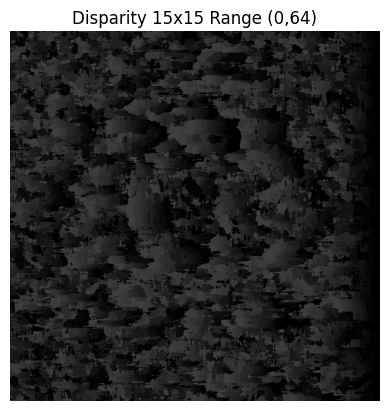

KeyboardInterrupt: 

In [9]:
if __name__ == "__main__":
    teddy()
    fish()